In [1]:
##---------------------------------------------------------------------
## Summary : Implementing the Skip-Gram model for generating WordEMB
## Author  : Srinivas Venkata Vemparala
## Source  : https://github.com/neubig/nn4nlp-code
##---------------------------------------------------------------------

%matplotlib inline
import numpy as np
import pandas as pd
import dynet as dy
import time 
import matplotlib.pyplot as plt
import random
from collections import defaultdict


In [2]:
# lets write a method to convert words to int
w2i = defaultdict(lambda:len(w2i))

S = w2i['<s>']
UNK = w2i['<unk>']

# lets write a method to read the data
def readDataset(fileName):
    retList = []
    with open(fileName,'r+') as f:
        for line in f:
            words = [w2i[x] for x in line.lower().strip().split(' ')]
            retList.append(words)
    return retList

In [3]:
# lets read the training and testing data. We are using the pen-tree-bank.
# In this the rare words are already replaced by <UNK>

train = readDataset('../data/ptb/train.txt')
test = readDataset('../data/ptb/valid.txt')

# lets freeze the dictionary
w2i = defaultdict(lambda:UNK, len(w2i))

# Now lets write a method to convert the indexes to words.
i2w = {v: k for k, v in w2i.items()}
# lets try an example
print(i2w[33])

nWords = len(w2i)
print('Vocabulary Size : ',nWords)

board
Vocabulary Size :  10000


In [4]:
# lets define the N in N-gram and length of each embedding
N = 2 # this means previous 2 words and next 2 words denote the context
nEMB = 64

# lets define the model and trainer
model = dy.Model()
trainer  = dy.SimpleSGDTrainer(model,learning_rate=0.1)

# lets add parameters to the model
W_emb = model.add_lookup_parameters((nWords,nEMB)) # embedding vectors
W_sm = model.add_parameters((nWords,nEMB))

In [5]:
# lets write a method to compute loss 
def computeLoss(sent):
    # lets renew computation graph
    dy.renew_cg()
    
    all_losses = []
    
    # get the embeddings for each word in sentence
    embList = [W_emb[x] for x in sent]   
    
    # get W_sm to computation graph
    weightsSoftMax = dy.parameter(W_sm)
      
    # iterate through each word in the sentence and compute the loss
    for i,embed in enumerate(embList):
        scores = dy.log_softmax(weightsSoftMax*embed)
        for j in range(1,N+1):
            all_losses.append(-1*dy.pick(scores, sent[i-j] if i-j >= 0 else S))
            all_losses.append(-1*dy.pick(scores, sent[i+j] if i+j < len(sent) else S)) 

    return dy.esum(all_losses)

In [6]:
# lets start the training and computing the embedding
trainLosses = []
testLosses = []

print('Started training ....')

for i in range(30):
    # randomly shuffle the training examples
    random.shuffle(train)
    
    trainLoss = 0.0
    startTime = time.time()
    numOfWordsProcessed = 0
    
    for sent in train:
        loss = computeLoss(sent)
        trainLoss = trainLoss+loss.value()
        
        numOfWordsProcessed = numOfWordsProcessed + len(sent)
        
        # do backward pass to compute the gradients and update parameters
        loss.backward()
        trainer.update()
    trainLosses.append(trainLoss)
    print('Iteration ',i,' : ',' TrainingLoss : ',(trainLoss/numOfWordsProcessed),' Number of words processed : ',numOfWordsProcessed,' Time taken : ',
         (time.time()-startTime))
    
    testLoss = 0.0
    for sent in test:
        loss = computeLoss(sent)
        testLoss = testLoss+loss.value()
    testLosses.append(testLoss)
    print('Iteration ',i,' : ',' TestLoss : ',(testLoss/numOfWordsProcessed))

Started training ....
Iteration  0  :   TrainingLoss :  25.628730324618804  Number of words processed :  887521  Time taken :  1049.2291421890259
Iteration  0  :   TestLoss :  1.9490424837455211
Iteration  1  :   TrainingLoss :  24.329137292105695  Number of words processed :  887521  Time taken :  1003.8135523796082
Iteration  1  :   TestLoss :  1.9286459315635112
Iteration  2  :   TrainingLoss :  24.037371530024913  Number of words processed :  887521  Time taken :  908.9124619960785
Iteration  2  :   TestLoss :  1.9159313928059334
Iteration  3  :   TrainingLoss :  23.855281858362947  Number of words processed :  887521  Time taken :  849.6308643817902
Iteration  3  :   TestLoss :  1.9146272804340638
Iteration  4  :   TrainingLoss :  23.722908319807885  Number of words processed :  887521  Time taken :  850.2638850212097
Iteration  4  :   TestLoss :  1.910843063763143
Iteration  5  :   TrainingLoss :  23.62019870648875  Number of words processed :  887521  Time taken :  846.584527015

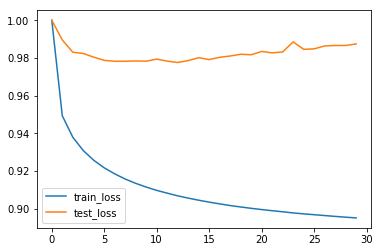

In [7]:
# normalize the training loss and test loss by dividing with initial element
trainLoss0 = trainLosses[0]
trainLosses = [(x/trainLoss0) for x in trainLosses]
    
testLoss0 = testLosses[0]
testLosses = [(x/testLoss0) for x in testLosses]
    
train_loss, = plt.plot(trainLosses,label='train_loss')
test_loss, = plt.plot(testLosses,label='test_loss')
plt.legend(handles=[train_loss,test_loss])
plt.show()

In [8]:
# lets write the input and output embeddings to file
inputEmbeddings = 'inputEmbeddingsSkipGram.txt'
outputEmbeddings = 'outputEmbeddingsSkipGram.txt'
labels = 'labelsSkipGram.txt'

with open(inputEmbeddings,'w') as f:
    embeddings = W_emb.as_array()
    for i in range(nWords):
        f.write('\t'.join(map(str,embeddings[i])) + '\n')

with open(outputEmbeddings,'w') as f:
    embeddings = W_sm.as_array()
    for i in range(nWords):
        f.write('\t'.join(map(str,embeddings[i])) + '\n')
        
with open(labels,'w') as f:
    for i in range(nWords):
        f.write(i2w[i] + '\n')    